### 1. Import the needed libs

In [1]:
import gym
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

# Set plotting options
# %matplotlib inline
# plt.style.use('ggplot')
np.set_printoptions(precision=3, linewidth=120)

### 2. Create an environment and set random seed

In [2]:
env = gym.make('MountainCar-v0')
seed = 505

#### 2.1. Explore the environment 

In [3]:
# Explore state (observation) space
print("State space:", env.observation_space)
print("low:", env.observation_space.low)
print("high:", env.observation_space.high)

State space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
low: [-1.2  -0.07]
high: [0.6  0.07]


In [4]:
# Explore the action space
print("Action space:", env.action_space)

# Generate some samples from the action space
print("Action space samples:",np.array([env.action_space.sample() for i in range(10)]))

Action space: Discrete(3)
Action space samples: [0 1 2 2 2 1 1 1 0 1]


### 3. Discretize the State Space with a Uniform Grid

In [3]:
def create_uniform_grid(low, high, bins=(10, 10)):
    """Create a uniformly spaced grid."""
    grid = [np.linspace(low[dim], high[dim], bins[dim] + 1)[1:-1] for dim in range(len(bins))]
    print("Uniform grid: [<low>, <high>] / <bins> => <splits>")
    for l, h, b, splits in zip(low, high, bins, grid):
        print("    [{}, {}] / {} => {}".format(l, h, b, splits))
    return grid

# example
low = [-1.0, -5.0]
high = [1.0, 5.0]
create_uniform_grid(low, high)

Uniform grid: [<low>, <high>] / <bins> => <splits>
    [-1.0, 1.0] / 10 => [-0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8]
    [-5.0, 5.0] / 10 => [-4. -3. -2. -1.  0.  1.  2.  3.  4.]


[array([-0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8]),
 array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.])]

#### Note: this function (discretize) is used only in clases and this is just an explaination

In [6]:
def discretize(sample, grid):
    """Discretize a sample as per given grid."""
    # np.digitize returns indix of the grid where sample falls
    return list(int(np.digitize(s, g)) for s, g in zip(sample, grid))


# example
grid = create_uniform_grid([-1.0, -5.0], [1.0, 5.0])
samples = np.array(
    [[-1.0 , -5.0],
     [-0.81, -4.1],
     [-0.8 , -4.0],
     [-0.5 ,  0.0],
     [ 0.2 , -1.9],
     [ 0.8 ,  4.0],
     [ 0.81,  4.1],
     [ 1.0 ,  5.0]])
discretized_samples = np.array([discretize(sample, grid) for sample in samples])
print("\nSamples:", repr(samples), sep="\n")
print("\nDiscretized samples:", repr(discretized_samples), sep="\n")

Uniform grid: [<low>, <high>] / <bins> => <splits>
    [-1.0, 1.0] / 10 => [-0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8]
    [-5.0, 5.0] / 10 => [-4. -3. -2. -1.  0.  1.  2.  3.  4.]

Samples:
array([[-1.  , -5.  ],
       [-0.81, -4.1 ],
       [-0.8 , -4.  ],
       [-0.5 ,  0.  ],
       [ 0.2 , -1.9 ],
       [ 0.8 ,  4.  ],
       [ 0.81,  4.1 ],
       [ 1.  ,  5.  ]])

Discretized samples:
array([[0, 0],
       [0, 0],
       [1, 1],
       [2, 5],
       [5, 3],
       [9, 9],
       [9, 9],
       [9, 9]])


### 4. Visualization

In [7]:
import matplotlib.collections as mc

def visualize_samples(samples, discretized_samples, grid, low=None, high=None):
    """Visualize original and discretized samples on a given 2-dimensional grid."""

    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Show grid
    ax.xaxis.set_major_locator(plt.FixedLocator(grid[0]))
    ax.yaxis.set_major_locator(plt.FixedLocator(grid[1]))
    ax.grid(True)
    
    # If bounds (low, high) are specified, use them to set axis limits
    if low is not None and high is not None:
        ax.set_xlim(low[0], high[0])
        ax.set_ylim(low[1], high[1])
    else:
        # Otherwise use first, last grid locations as low, high (for further mapping discretized samples)
        low = [splits[0] for splits in grid]
        high = [splits[-1] for splits in grid]

    # Map each discretized sample (which is really an index) to the center of corresponding grid cell
    grid_extended = np.hstack((np.array([low]).T, grid, np.array([high]).T))  # add low and high ends
    # print("\nGrid extended:", repr(grid_extended), sep="\n")
    grid_centers = (grid_extended[:, 1:] + grid_extended[:, :-1]) / 2  # compute center of each grid cell
    # print("Grid centers:", repr(grid_centers), sep="\n")
    locs = np.stack(grid_centers[i, discretized_samples[:, i]] for i in range(len(grid))).T  # map discretized samples
    # print("Discretized samples mapped to grid centers:", repr(locs), sep="\n")

    ax.plot(samples[:, 0], samples[:, 1], 'o')  # plot original samples
    ax.plot(locs[:, 0], locs[:, 1], 's')  # plot discretized samples in mapped locations
    ax.add_collection(mc.LineCollection(list(zip(samples, locs)), colors='orange'))  # add a line connecting each original-discretized sample
    ax.legend(['original', 'discretized'])

#### 4.1. Create grid and check the difference between the cont. and discretized values

Uniform grid: [<low>, <high>] / <bins> => <splits>
    [-1.2000000476837158, 0.6000000238418579] / 10 => [-1.02 -0.84 -0.66 -0.48 -0.3  -0.12  0.06  0.24  0.42]
    [-0.07000000029802322, 0.07000000029802322] / 10 => [-0.056 -0.042 -0.028 -0.014  0.     0.014  0.028  0.042  0.056]


C:\Users\basel\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py:3251: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


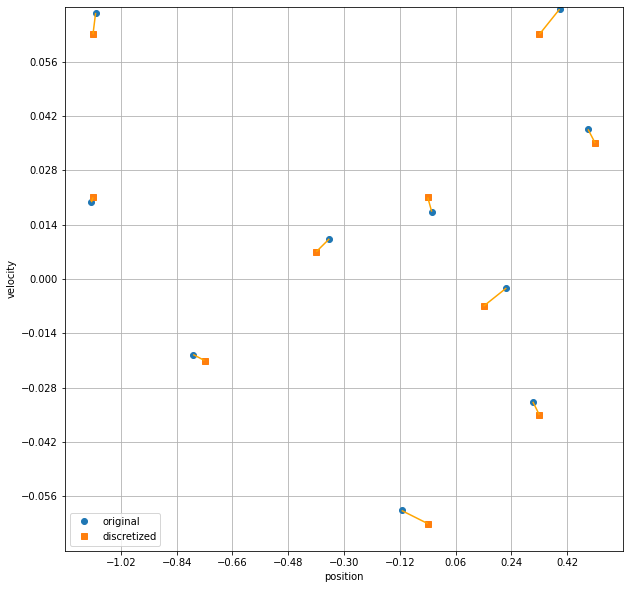

In [8]:
# Create a grid to discretize the state space
state_grid = create_uniform_grid(env.observation_space.low, env.observation_space.high, bins=(10, 10))

# Obtain some samples from the space, discretize them, and then visualize them
state_samples = np.array([env.observation_space.sample() for i in range(10)])
discretized_state_samples = np.array([discretize(sample, state_grid) for sample in state_samples])

visualize_samples(state_samples, discretized_state_samples, state_grid,
                  env.observation_space.low, env.observation_space.high)
plt.xlabel('position')
plt.ylabel('velocity')
plt.show()

### 5. Q-Learning

In [9]:
%run -i q_learning.py
q_agent = QLearningAgent(env, state_grid)

Environment: <TimeLimit<OrderEnforcing<MountainCarEnv<MountainCar-v0>>>>
State space size: (10, 10)
Action space size: 3
Q table size: (10, 10, 3)


In [10]:
q_train_scores = q_agent.run(num_episodes=7500, mode='train')
q_test_scores = q_agent.run(num_episodes=500, mode='test')

Episode 100/7500 | Average Score: -200.00
Episode 200/7500 | Average Score: -200.00
Episode 300/7500 | Average Score: -200.00
Episode 400/7500 | Average Score: -200.00
Episode 500/7500 | Average Score: -200.00
Episode 600/7500 | Average Score: -200.00
Episode 700/7500 | Average Score: -200.00
Episode 800/7500 | Average Score: -200.00
Episode 900/7500 | Average Score: -200.00
Episode 1000/7500 | Average Score: -200.00
Episode 1100/7500 | Average Score: -200.00
Episode 1200/7500 | Average Score: -200.00
Episode 1300/7500 | Average Score: -200.00
Episode 1400/7500 | Average Score: -200.00
Episode 1500/7500 | Average Score: -200.00
Episode 1600/7500 | Average Score: -199.99
Episode 1700/7500 | Average Score: -199.97
Episode 1800/7500 | Average Score: -199.90
Episode 1900/7500 | Average Score: -199.88
Episode 2000/7500 | Average Score: -199.86
Episode 2100/7500 | Average Score: -199.74
Episode 2200/7500 | Average Score: -199.72
Episode 2300/7500 | Average Score: -199.71
Episode 2400/7500 | 

### 6. Monte carlo

In [11]:
%run -i monte_carlo.py
monte_carlo_agent = MonteCarloAgent(
    env=env,
    state_grid=state_grid
)

Environment: <TimeLimit<OrderEnforcing<MountainCarEnv<MountainCar-v0>>>>
State space size: (10, 10)
Action space size: 3
Q table size: (10, 10, 3)


In [12]:
monte_carlo_train_scores = monte_carlo_agent.run(num_episodes=7500, mode="train")
monte_carlo_test_scores = monte_carlo_agent.run(num_episodes=500, mode="test")

Episode 100/7500 | Average Score: -200.00
Episode 200/7500 | Average Score: -200.00
Episode 300/7500 | Average Score: -200.00
Episode 400/7500 | Average Score: -200.00
Episode 500/7500 | Average Score: -200.00
Episode 600/7500 | Average Score: -200.00
Episode 700/7500 | Average Score: -200.00
Episode 800/7500 | Average Score: -200.00
Episode 900/7500 | Average Score: -200.00
Episode 1000/7500 | Average Score: -200.00
Episode 1100/7500 | Average Score: -200.00
Episode 1200/7500 | Average Score: -200.00
Episode 1300/7500 | Average Score: -200.00
Episode 1400/7500 | Average Score: -200.00
Episode 1500/7500 | Average Score: -200.00
Episode 1600/7500 | Average Score: -200.00
Episode 1700/7500 | Average Score: -200.00
Episode 1800/7500 | Average Score: -200.00
Episode 1900/7500 | Average Score: -200.00
Episode 2000/7500 | Average Score: -200.00
Episode 2100/7500 | Average Score: -200.00
Episode 2200/7500 | Average Score: -200.00
Episode 2300/7500 | Average Score: -200.00
Episode 2400/7500 | 

### 7. SARSA

In [13]:
%run -i sarsa.py
sars_agent = SARSAagent(
    env=env,
    state_grid=state_grid)

Environment: <TimeLimit<OrderEnforcing<MountainCarEnv<MountainCar-v0>>>>
State space size: (10, 10)
Action space size: 3
Q table size: (10, 10, 3)


In [14]:
sars_train_scores = sars_agent.run(num_episodes=7500, mode="train")
sars_test_scores = sars_agent.run(num_episodes=500, mode="test")

Episode 100/7500 | Average Score: -200.00
Episode 200/7500 | Average Score: -200.00
Episode 300/7500 | Average Score: -200.00
Episode 400/7500 | Average Score: -200.00
Episode 500/7500 | Average Score: -200.00
Episode 600/7500 | Average Score: -200.00
Episode 700/7500 | Average Score: -200.00
Episode 800/7500 | Average Score: -200.00
Episode 900/7500 | Average Score: -200.00
Episode 1000/7500 | Average Score: -200.00
Episode 1100/7500 | Average Score: -200.00
Episode 1200/7500 | Average Score: -199.99
Episode 1300/7500 | Average Score: -199.99
Episode 1400/7500 | Average Score: -199.96
Episode 1500/7500 | Average Score: -199.96
Episode 1600/7500 | Average Score: -199.94
Episode 1700/7500 | Average Score: -199.91
Episode 1800/7500 | Average Score: -199.89
Episode 1900/7500 | Average Score: -199.71
Episode 2000/7500 | Average Score: -199.64
Episode 2100/7500 | Average Score: -199.45
Episode 2200/7500 | Average Score: -199.41
Episode 2300/7500 | Average Score: -199.23
Episode 2400/7500 | 

### 8. Comparison

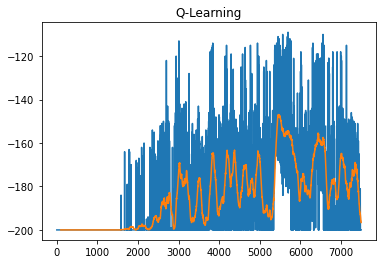

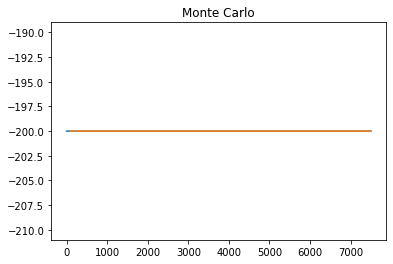

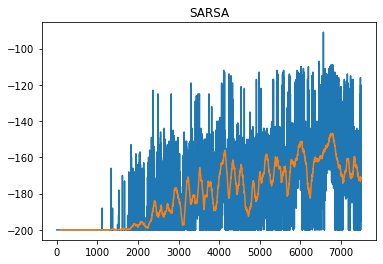

In [15]:
def plot_scores(scores, rolling_window=100,title="Scores"):
    """Plot scores and optional rolling mean using specified window."""
    plt.plot(scores) 
    plt.title(title)
    rolling_mean = pd.Series(scores).rolling(rolling_window).mean()
    plt.plot(rolling_mean)
    plt.show()
    return rolling_mean

q_rolling_mean = plot_scores(q_train_scores, rolling_window=100,title="Q-Learning")
monte_rolling_mean = plot_scores(monte_carlo_train_scores, rolling_window=100,title="Monte Carlo")
sars_rolling_mean = plot_scores(sars_train_scores, rolling_window=100,title="SARSA")


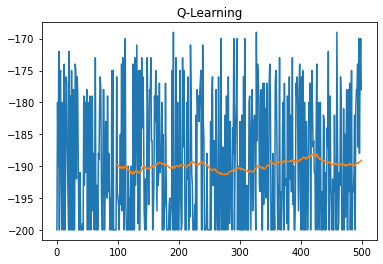

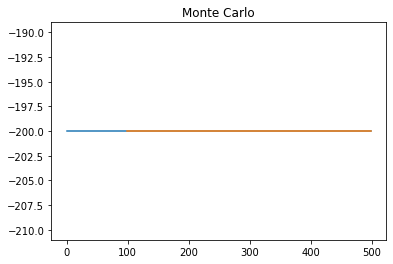

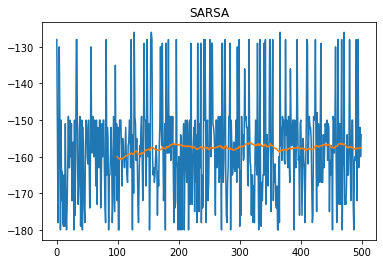

In [16]:
def plot_scores(scores, rolling_window=100,title="Scores"):
    """Plot scores and optional rolling mean using specified window."""
    plt.plot(scores) 
    plt.title(title)
    rolling_mean = pd.Series(scores).rolling(rolling_window).mean()
    plt.plot(rolling_mean)
    plt.show()
    return rolling_mean

q_rolling_mean = plot_scores(q_test_scores, rolling_window=100,title="Q-Learning")
monte_rolling_mean = plot_scores(monte_carlo_test_scores, rolling_window=100,title="Monte Carlo")
sars_rolling_mean = plot_scores(sars_test_scores, rolling_window=100,title="SARSA")


It's also interesting to look at the final Q-table that is learned by the agent. Note that the Q-table is of size MxNxA, where (M, N) is the size of the state space, and A is the size of the action space. We are interested in the maximum Q-value for each state, and the corresponding (best) action associated with that value.

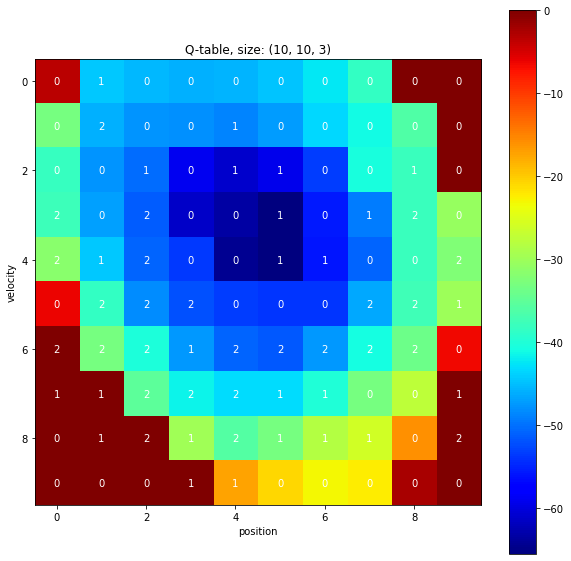

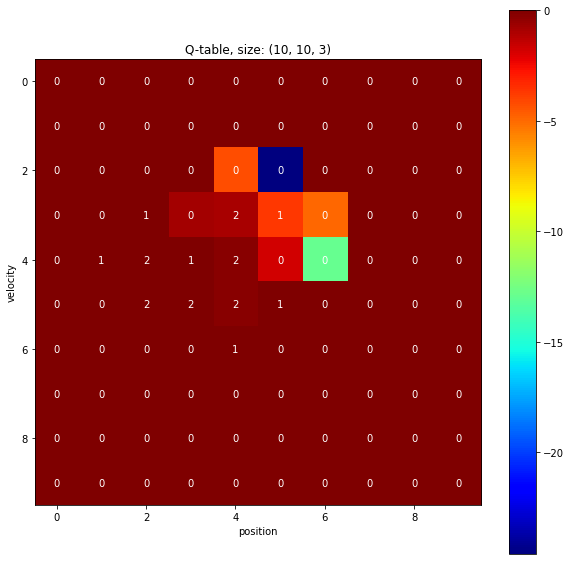

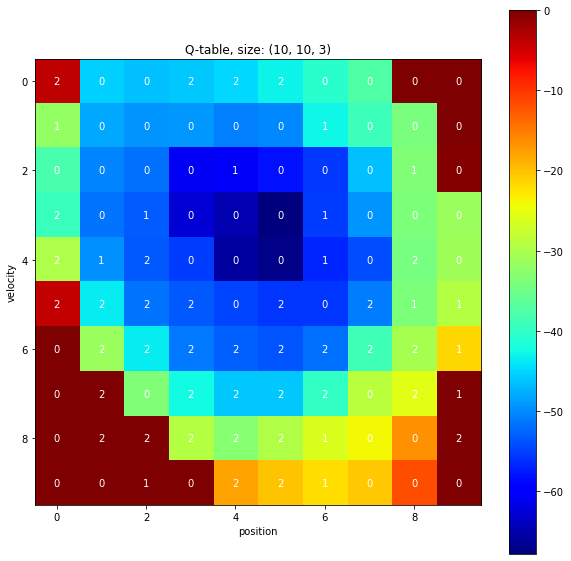

In [17]:
def plot_q_table(q_table):
    """Visualize max Q-value for each state and corresponding action."""
    q_image = np.max(q_table, axis=2)       # max Q-value for each state
    q_actions = np.argmax(q_table, axis=2)  # best action for each state

    fig, ax = plt.subplots(figsize=(10, 10))
    cax = ax.imshow(q_image, cmap='jet')
    cbar = fig.colorbar(cax)
    for x in range(q_image.shape[0]):
        for y in range(q_image.shape[1]):
            ax.text(x, y, q_actions[x, y], color='white',
                    horizontalalignment='center', verticalalignment='center')
    ax.grid(False)
    ax.set_title("Q-table, size: {}".format(q_table.shape))
    ax.set_xlabel('position')
    ax.set_ylabel('velocity')


plot_q_table(q_agent.q_table)
plot_q_table(monte_carlo_agent.q_table)
plot_q_table(sars_agent.q_table)


In [21]:
print("Q-Learning accuracy: \n")
q_agent.run(num_episodes=100, mode='test')
print("\nMonte Carlo accuracy:    \n")
monte_carlo_agent.run(num_episodes=100, mode='test')
print("\nSARSA accuracy:  \n")
sars_agent.run(num_episodes=100, mode='test')
print("\n")

Q-Learning accuracy: 

Episode 100/100 | Average Score: -188.75
Monte Carlo accuracy:    

Episode 100/100 | Average Score: -200.00
SARSA accuracy:  

Episode 100/100 | Average Score: -157.14



### 9. saving q tables


In [23]:
np.save(f"qtables/Q_learning-qtable.npy", q_agent.q_table)
np.save(f"qtables/Monte_carlo-qtable.npy", monte_carlo_agent.q_table)
np.save(f"qtables/SARSA-qtable.npy", sars_agent.q_table)

### 10. Loading q tables and checking accuracy

In [13]:
env = gym.make('MountainCar-v0')
state_grid = create_uniform_grid(env.observation_space.low, env.observation_space.high, bins=(10, 10))

%run -i q_learning.py
%run -i monte_carlo.py
%run -i sarsa.py


new_q_agent = QLearningAgent(env, state_grid)
new_q_agent.q_table = np.load(f"qtables/Q_learning-qtable.npy")
print("\nQ-Learning accuracy:    \n")
new_q_agent.run(num_episodes=100, mode='test')
print("\n")
print("\rAccuracy = {:.2f}%".format(new_q_agent.calculate_accuracy(num_episodes=100)*100))

new_monte_carlo_agent = MonteCarloAgent(env, state_grid)
new_monte_carlo_agent.q_table = np.load(f"qtables/Monte_carlo-qtable.npy")
print("\nMonte Carlo accuracy:    \n")
new_monte_carlo_agent.run(num_episodes=100, mode='test')
print("\n")
print("\rAccuracy = {:.2f}%".format(new_monte_carlo_agent.calculate_accuracy(num_episodes=100)*100))

new_sars_agent = SARSAagent(env, state_grid)
new_sars_agent.q_table = np.load(f"qtables/SARSA-qtable.npy")
print("\nSARSA accuracy:  \n")
new_sars_agent.run(num_episodes=100, mode='test')
print("\n")
print("\rAccuracy = {:.2f}%".format(new_sars_agent.calculate_accuracy(num_episodes=100)*100))

Uniform grid: [<low>, <high>] / <bins> => <splits>
    [-1.2000000476837158, 0.6000000238418579] / 10 => [-1.02 -0.84 -0.66 -0.48 -0.3  -0.12  0.06  0.24  0.42]
    [-0.07000000029802322, 0.07000000029802322] / 10 => [-0.056 -0.042 -0.028 -0.014  0.     0.014  0.028  0.042  0.056]
Environment: <TimeLimit<OrderEnforcing<MountainCarEnv<MountainCar-v0>>>>
State space size: (10, 10)
Action space size: 3
Q table size: (10, 10, 3)

Q-Learning accuracy:    

Episode 100/100 | Average Score: -190.17

Accuracy = 66.00%
Environment: <TimeLimit<OrderEnforcing<MountainCarEnv<MountainCar-v0>>>>
State space size: (10, 10)
Action space size: 3
Q table size: (10, 10, 3)

Monte Carlo accuracy:    

Episode 100/100 | Average Score: -200.00

Accuracy = 0.00%
Environment: <TimeLimit<OrderEnforcing<MountainCarEnv<MountainCar-v0>>>>
State space size: (10, 10)
Action space size: 3
Q table size: (10, 10, 3)

SARSA accuracy:  

Episode 100/100 | Average Score: -160.70

Accuracy = 100.00%
